### Importação das bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.interpolate import griddata

### Cálculo do Campo Elétrico

**Explicação Matemática:**
O código aproxima as derivadas parciais $\frac{\partial V}{\partial x}$ e $\frac{\partial V}{\partial y}$ usando diferenças finitas centralizadas. Para um ponto $(x, y)$, as derivadas são aproximadas da seguinte forma:

1.  **Derivada em relação a x:**

    $$\frac{\partial V}{\partial x} \approx \frac{V(x + \Delta x, y) - V(x - \Delta x, y)}{2\Delta x}$$

    No código, $V(x + \Delta x, y)$ é aproximado por `V_direita` e $V(x - \Delta x, y)$ por `V_esquerda`, e $\Delta x$ é aproximado por `dx`. Portanto, a componente x do campo elétrico $E_x$ é calculada como:

    $$E_x \approx -\frac{V_{\text{direita}} - V_{\text{esquerda}}}{dx}$$

2.  **Derivada em relação a y:**

    Similarmente a x mas para cima e para baixo.

3.  **A magnitude do campo elétrico $E_{\text{norm}}$**

    $$E_{\text{norm}} = \sqrt{E_x^2 + E_y^2}$$

Utilizei a biblioteca `NearestNeighbors` para encontrar os vizinhos próximos a cada ponto. O parâmetro `delta` controla a distância para encontrar os vizinhos.

In [2]:
# Função para Calcular o Campo Elétrico
def calcular_campo_eletrico(data, delta=1.0):
    pontos = data[['x', 'y']].values
    nn = NearestNeighbors(n_neighbors=10, metric='euclidean')
    nn.fit(pontos)
    
    E_x = np.full(len(data), np.nan)
    E_y = np.full(len(data), np.nan)
    
    for i, (x, y, V) in enumerate(data[['x', 'y', 'V']].values):
        # Derivada em x
        vizinhos_direita = nn.radius_neighbors([[x + delta, y]], delta * 1.5, return_distance=True)
        vizinhos_esquerda = nn.radius_neighbors([[x - delta, y]], delta * 1.5, return_distance=True)
        
        if vizinhos_direita[0][0].size > 0 and vizinhos_esquerda[0][0].size > 0:
            V_direita = data.iloc[vizinhos_direita[1][0]]['V'].mean()
            V_esquerda = data.iloc[vizinhos_esquerda[1][0]]['V'].mean()
            dx = (vizinhos_direita[0][0].mean() + vizinhos_esquerda[0][0].mean())
            E_x[i] = -(V_direita - V_esquerda) / dx
        
        # Derivada em y
        vizinhos_cima = nn.radius_neighbors([[x, y + delta]], delta * 1.5, return_distance=True)
        vizinhos_baixo = nn.radius_neighbors([[x, y - delta]], delta * 1.5, return_distance=True)
        
        if vizinhos_cima[0][0].size > 0 and vizinhos_baixo[0][0].size > 0:
            V_cima = data.iloc[vizinhos_cima[1][0]]['V'].mean()
            V_baixo = data.iloc[vizinhos_baixo[1][0]]['V'].mean()
            dy = (vizinhos_cima[0][0].mean() + vizinhos_baixo[0][0].mean())
            E_y[i] = -(V_cima - V_baixo) / dy
    
    data['E_x'] = E_x
    data['E_y'] = E_y
    data['E_norm'] = np.sqrt(E_x**2 + E_y**2)
    return data

### Carregar e Processar Dados
Carrega dados de um arquivo CSV, calcula o campo elétrico e remove linhas com valores ausentes.

1.  **`carregar_e_processar_dados`:** Carrega os dados de um arquivo CSV, calcula o campo elétrico usando a função `calcular_campo_eletrico` e remove linhas com valores ausentes.

2.  **`gerar_grafico_normal`:** Gera um gráfico de vetores do campo elétrico usando os dados originais (sem interpolação).

3.  **`gerar_grafico_interpolado`:** Interpola os dados do campo elétrico em uma grade regular e gera um gráfico de vetores do campo elétrico interpolado. A interpolação é realizada usando a função `griddata` do SciPy.

In [30]:
# Função para carregar e processar os dados
def carregar_e_processar_dados(csv_file, delta=2.0):
    data = pd.read_csv(csv_file)
    data = calcular_campo_eletrico(data, delta=delta)
    data_clean = data.dropna(subset=['E_x', 'E_y'])
    return data, data_clean

# Função para gerar o gráfico do campo elétrico
def gerar_grafico_campo_eletrico(csv_file, data, data_clean, scale, title, interpolar=False):
    plt.figure(figsize=(12, 10))

    if interpolar:
        # Criar grade para interpolação
        grid_x, grid_y = np.mgrid[data['x'].min()-3:data['x'].max()+1:100j, data['y'].min()-2:data['y'].max()+1:100j]

        # Interpolar os componentes do campo elétrico - CORREÇÃO: grid_y foi usado incorretamente
        E_x_interp = griddata((data_clean['x'], data_clean['y']), data_clean['E_x'], (grid_x, grid_y), method='cubic')
        E_y_interp = griddata((data_clean['x'], data_clean['y']), data_clean['E_y'], (grid_x, grid_y), method='cubic')

        # Plotar os vetores do campo elétrico interpolados
        plt.quiver(
            grid_x[::5, ::5], grid_y[::5, ::5], 
            E_x_interp[::5, ::5], E_y_interp[::5, ::5], 
            scale=scale, color='#4a90e2', width=0.004,
            headlength=4, headaxislength=3, label='Campo Elétrico'
        )
        plt.title(f'Vetores Campo Elétrico (Dados Interpolados, Escala 1:{scale} da norma) - {title}', fontsize=14)
        nome_arquivo = f'campo_eletrico_interpolado_{csv_file[:-4]}_scale_{scale}.png'
    else:
        # Plotar os vetores do campo elétrico
        plt.quiver(
            data_clean['x'], data_clean['y'], 
            data_clean['E_x'], data_clean['E_y'], 
            scale=scale, color='#4a90e2', width=0.004,
            headlength=4, headaxislength=3, label='Campo Elétrico'
        )
        plt.title(f'Vetores Campo Elétrico (Dados Normais, Escala 1:{scale} da norma) - {title}', fontsize=14)
        nome_arquivo = f'campo_eletrico_normal_{csv_file[:-4]}_scale_{scale}.png'

    # Configurações do gráfico
    plt.xlabel('x (cm)', fontsize=12)
    plt.ylabel('y (cm)', fontsize=12)
    plt.grid(alpha=0.3)
    if scale == 10:
        plt.xlim(data['x'].min() - 5, data['x'].max() + 5)
    else:
        plt.xlim(data['x'].min() - 3, data['x'].max() + 1)
    plt.ylim(data['y'].min() - 2, data['y'].max() + 1)

    # Adicionar eletrodos de acordo com o tipo de arquivo
    if csv_file == "dados1.csv":
        # Para o dipolo - pontos
        plt.plot(-10, 0, 'o', markersize=10, color='#00cc44', label='Eletrodo +')
        plt.plot(10, 0, 'o', markersize=10, color='#ff007f', label='Eletrodo -')
    elif csv_file in ["dados2.csv", "dados3.csv"]:
        # Para placas paralelas - barras verticais de altura finita (-5 a +5)
        bar_width = 0.125
        bar_height = [-5, 5]  # Altura finita das barras
        
        # Barra positiva (esquerda)
        plt.fill_betweenx(bar_height, -10-bar_width/2, -10+bar_width/2, color='#00cc44', alpha=0.7, label='Eletrodo +')
        
        # Barra negativa (direita)
        plt.fill_betweenx(bar_height, 10-bar_width/2, 10+bar_width/2, color='#ff007f', alpha=0.7, label='Eletrodo -')
        
        # Adicionar o cilindro para o dados3.csv
        if csv_file == "dados3.csv":
            circle = plt.Circle((0, 0), 2, fill=False, color='gray', linestyle='-', linewidth=2, label='Cilindro')
            plt.gca().add_patch(circle)
            
    # Garantir que o círculo apareça como um círculo e não uma elipse
    plt.axis('equal')
    
    plt.legend()

    plt.savefig(nome_arquivo, dpi=300)
    plt.show()

### Geração dos Gráficos para Diferentes Conjuntos de Dados

Itera sobre uma lista de arquivos CSV, carrega e processa os dados de cada arquivo, define parâmetros específicos para cada conjunto de dados (como a escala dos vetores) e gera gráficos tanto com os dados originais quanto com os dados interpolados.

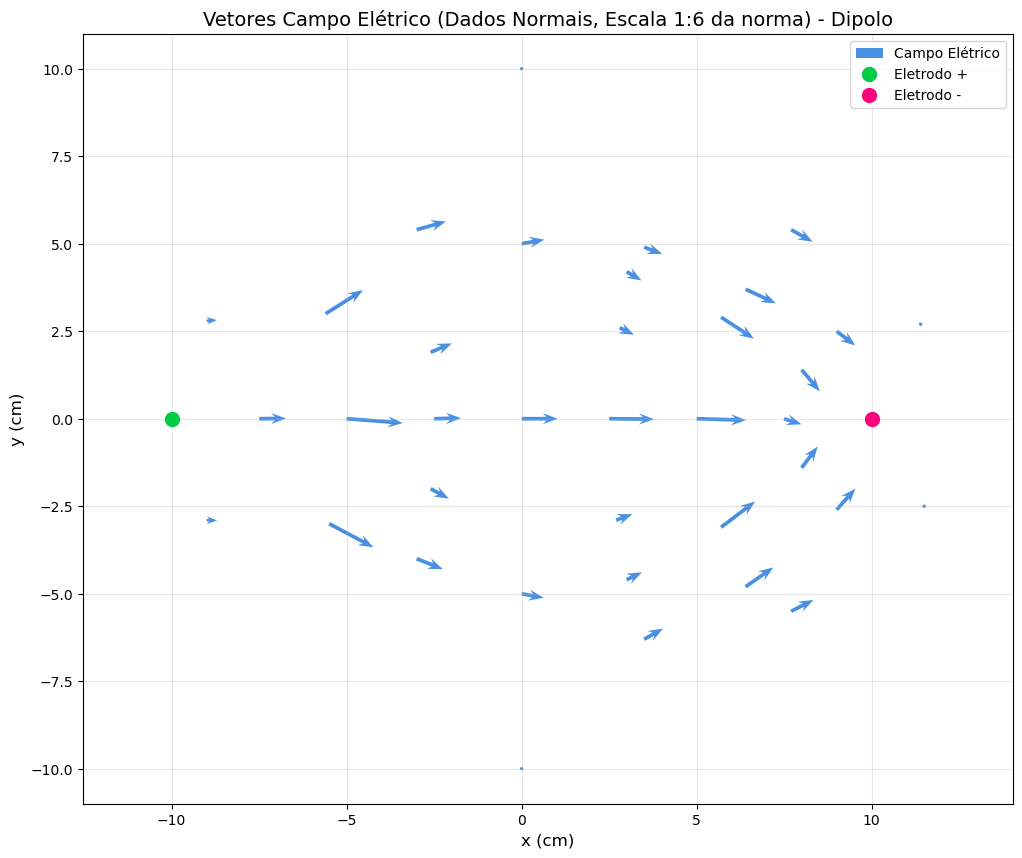

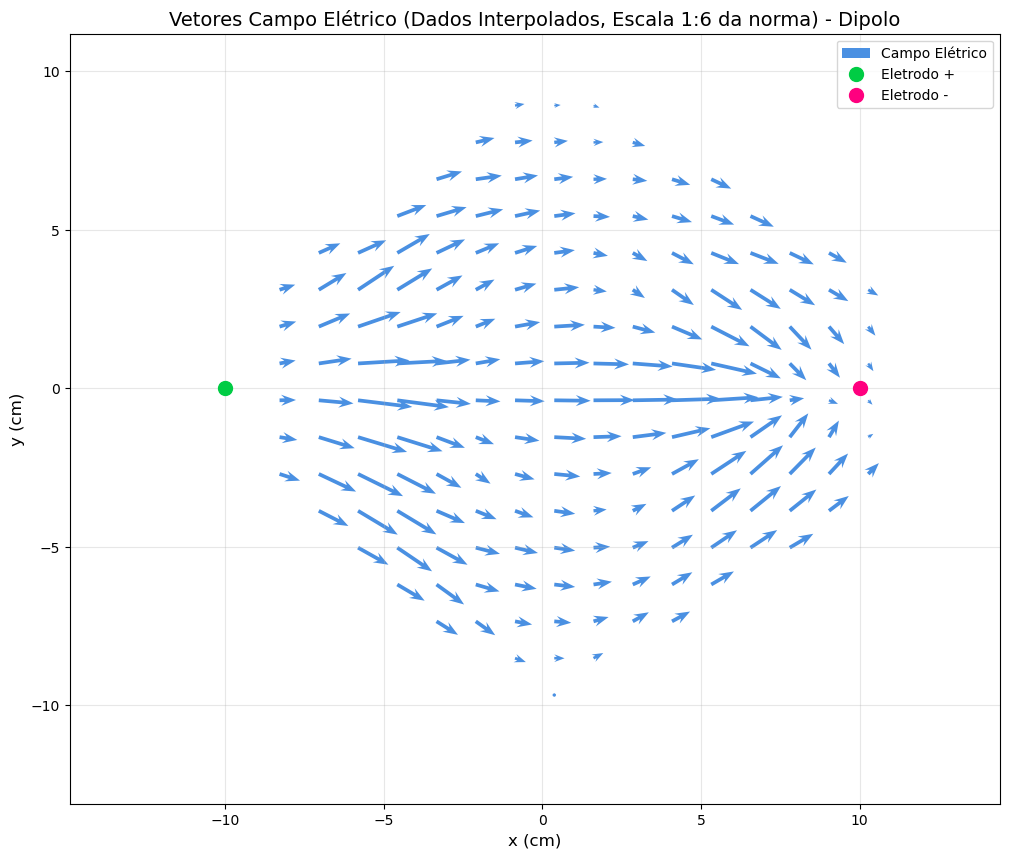

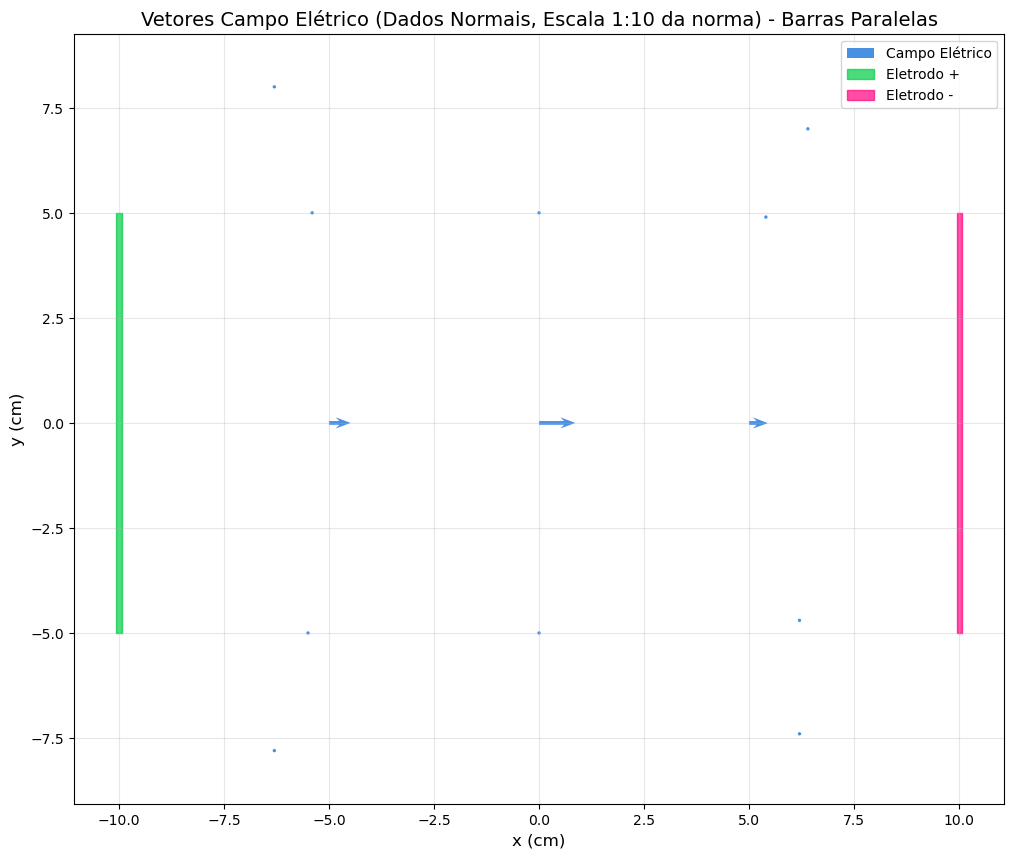

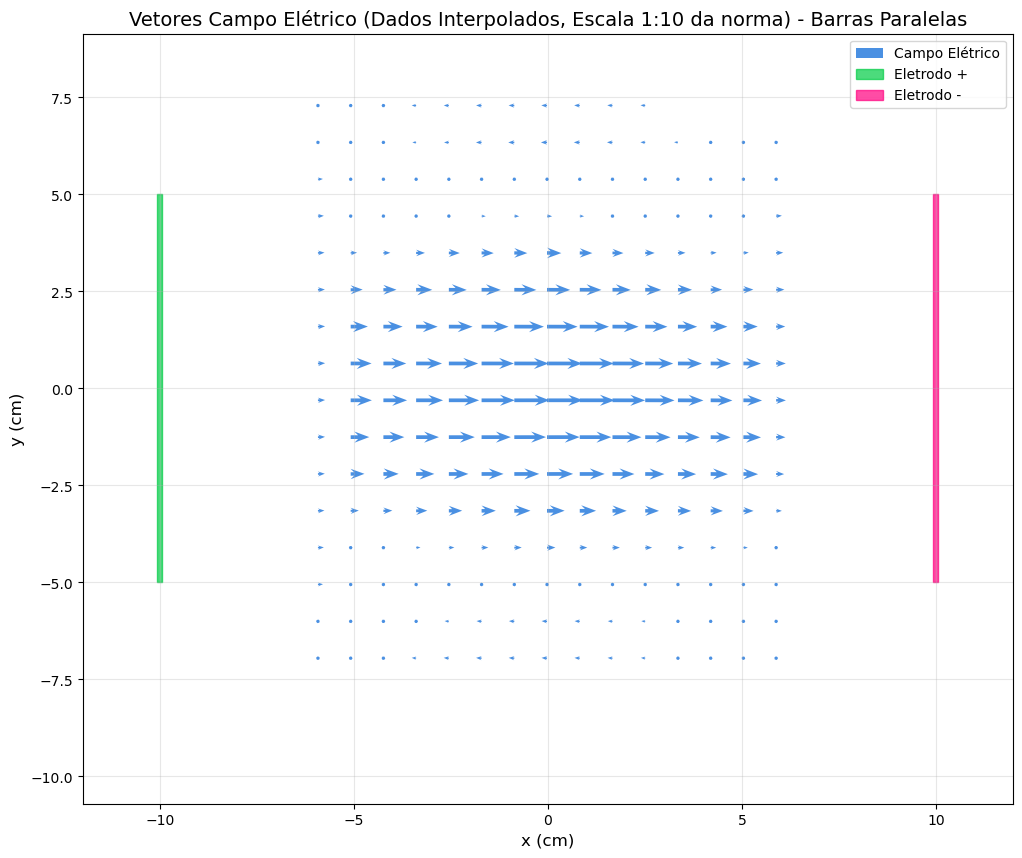

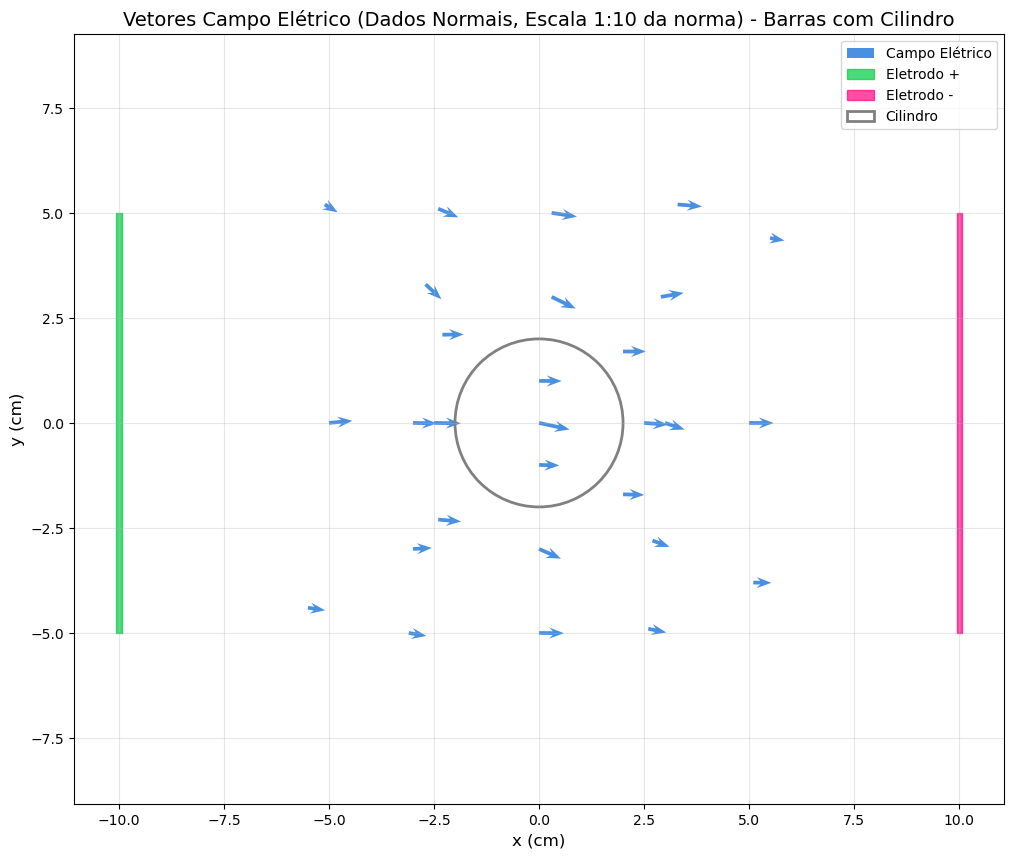

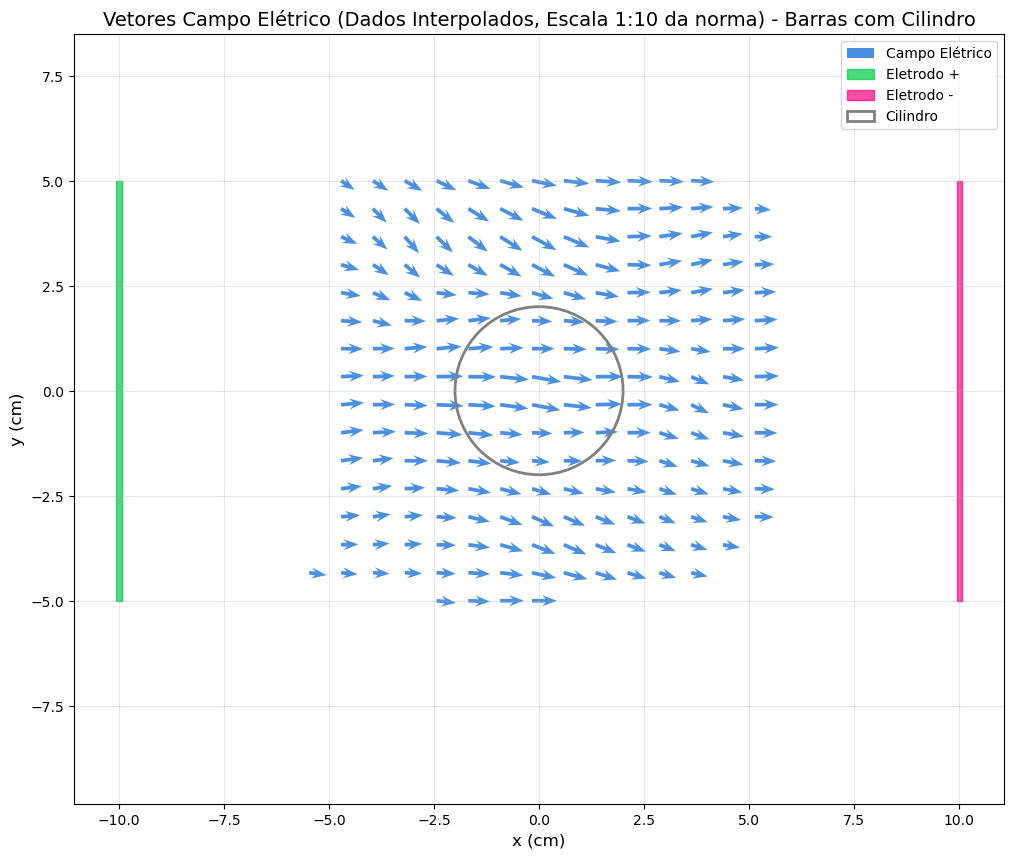

In [32]:
# Lista de arquivos CSV
csv_files = ["dados1.csv", "dados2.csv", "dados3.csv"]

# Dicionário para mapear os títulos
titles = {
    "dados1.csv": "Dipolo",
    "dados2.csv": "Barras Paralelas",
    "dados3.csv": "Barras com Cilindro"
}

# Gerar gráficos para cada arquivo
for csv_file in csv_files:
    data, data_clean = carregar_e_processar_dados(csv_file)
    
    # Definir o valor de scale com base no nome do arquivo
    if csv_file == "dados1.csv":
        scale_normal = 6
        scale_interp = 6
    else:
        scale_normal = 10
        scale_interp = 10
    
    # Obter o título do dicionário
    title = titles[csv_file]
    
    gerar_grafico_campo_eletrico(csv_file, data, data_clean, scale_normal, title, interpolar=False)
    gerar_grafico_campo_eletrico(csv_file, data, data_clean, scale_interp, title, interpolar=True)